In [1]:
import sys
import os
sys.path.append('../utils_meinhold')
sys.path.append('../utils_zonca')
sys.path.append('../utils_zonca/pointing')
sys.path.append('../')
sys.path.append('../telescope_control')
sys.path.append('../VtoT')
print os.getcwd()
import convert
import realtime_gp as rt
import numpy as np
import h5py
import pandas as pd
#from pointingtools import compute_parallactic_angle, altaz2ha 
#from planets import getlocation, getpointing
import warnings
from astropy.coordinates import AltAz, Angle, EarthLocation, ICRS, SkyCoord, frame_transform_graph, get_sun
from astropy import units as u
#import ephem
import matplotlib.pyplot as plt
import time
#import planets
from datetime import datetime, date, timedelta
import numpy.ma as ma
from astropy.time import Time
from mpl_toolkits.axes_grid1 import make_axes_locatable

import Tkinter,tkFileDialog

from Tkinter import *
import ttk

import pickle
import glob

import cPickle
from scipy import signal, stats
from scipy.signal import savgol_filter

%pylab

D:\software_git_repos\Polaris\polaris_software\notebook


C:\Users\labuser\anaconda3\envs\py27\lib\site-packages\pyfits\__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


C:\Users\labuser\anaconda3\envs\py27\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['Widget', 'Text', 'Button', 'datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
#%matplotlib auto

In [3]:
def get_pointing_files(filelist=None):

    if filelist==None:
        root=Tkinter.Tk()
        filelist = list(tkFileDialog.askopenfilenames(\
        initialdir='D://software_git_repos/greenpol/telescope_control/data_aquisition/pointing_data/',parent=root,title='Choose a set of files'))
        root.destroy()
    filelist.sort()
    
    return filelist

In [4]:
def read_some_data(filelist=None):

    if filelist==None:
        root=Tkinter.Tk()
        filelist = list(tkFileDialog.askopenfilenames(\
        initialdir='D://software_git_repos/greenpol/telescope_control/data_aquisition/demod_data/',parent=root,title='Choose a set of files'))
        root.destroy()
    filelist.sort()
    
    dlist=[]
    for f in filelist:
        hf=h5py.File(f)
        dlist.append(hf['demod_data'])
    d=np.concatenate(dlist)
    hf.close() 

    datadict=d
        
    return datadict, filelist

In [5]:
def get_file_times(fld):
    startfile = fld[0][:65]+fld[0][71:-2]+'dat'
    endfile = fld[-1][:65]+fld[-1][71:-2]+'dat'
    
    #starttime = os.path.getctime(startfile)
    starttime= os.stat(startfile).st_mtime
    starttime = datetime.datetime.fromtimestamp(starttime)

    #endtime = os.path.getctime(endfile)
    endtime= os.stat(endfile).st_mtime
    endtime = datetime.datetime.fromtimestamp(endtime)
    
    return starttime, endtime

In [6]:
def plotnow_azrevsig(data, az, chan, var, minmax=None,return_map=False):
    #flp=select_h5(fpath,yrmoday,st_hour,st_minute,ed_hour,ed_minute)
    #fld_demod, fld =select_dat(fpath,yrmoday,st_hour,st_minute,ed_hour,ed_minute)
    #i=0
    #while len(flp)<3:
    #	i+=1
    #	flp=select_h5(fpath,yrmoday,st_hour,int(st_minute)-i,ed_hour,int(ed_minute)+i)

    #pp=rt.get_h5_pointing(flp)
    ##dd=get_demodulated_data_from_list(fld,supply_index=supply_index)
    #dd=rt.get_all_demodulated_data(fld_demod, fld)
    #combined=rt.combine_cofe_h5_pointing(dd,pp)

    #synchronized data and az values
    az1 = az
    data1 = data
    steps = len(data1)

    #convert to temp for cryo sensors
    if chan == 12:
        data1 = convert.convert(data1, 'i')
    if chan == 13:
        data1 = convert.convert(data1, 'e')
    if chan == 14:
        data1 = convert.convert(data1, 'h')
    if chan == 15:
        data1 = convert.convert(data1, 'l')

    #resolution
    dx = 1.0
    dy = 1.0

    #set up empty lists to append each revolution to
    data = []
    az = []
    iaz = [0]
    rev = 0

    #determine indices in azimuth/data array which correspond to a new revolution of the telescope
    for i in range(steps):
        #round values to resolution for comparison later
        az1[i] = rt.round_fraction(az1[i], dx)
        if i > 0:
            if abs(az1[i] - az1[i-1]) >= 180.:
                iaz.append(i)
                rev += 1

    #append each revolution array to a list	    
    for j in range(rev):
        az.append(az1[iaz[j]:iaz[j+1]])
        data.append(data1[iaz[j]:iaz[j+1]])

    #append the last revolution
    data.append(data1[iaz[-1]:])
    az.append(az1[iaz[-1]:])
    rev += 1

    print rev

    data = np.asarray(data)
    az = np.asarray(az)

    #create grid for plotting
    x, y = np.arange(0., 360.+dx, dx), np.arange(0., rev - 1 + dy, dy)
    AZ, REV = np.meshgrid(x, y)

    #set up empty array
    z = np.zeros(len(x)*len(y))
    sig = np.reshape(z, (len(y), len(x)))

    #small number for comparing floats
    epsilon = dx

    #fill signal array with data points
    for r in range(rev):
        for a in range(len(x)):
            #find indices where combined azimuth data fits on x grid
            idx = np.where(abs(az[r] - x[a]) < epsilon)[0]
            #if idx length is 0 this will create a mask on that point, in idx len > 1, avg data points in the same bin
            sig[r][a] = data[r][idx].mean()

    #mask invalid values, i.e. where there are no data points
    sig = ma.masked_invalid(sig)

    #change units on plot label
    if int(chan[2:]) < 12:
        unit = 'V'
    else:
        unit = 'K' 

    name = rt.chantoname(chan)
    
    if return_map:
        return sig, AZ, REV
    else:

        plt.pcolormesh(AZ, REV, sig, cmap='jet')
        plt.colorbar(label = 'Signal, %s' % unit)
        if minmax != None:
            plt.clim(minmax[0],minmax[1])
        else:  
            plt.clim(data1.min(),data1.max())    #plt.clim(-1.0,1.0)
        plt.axis([0., 360., 0., rev - 1])
        plt.ylabel('revolution #')
        plt.xlabel('azimuth (deg)')
        plt.title('%s %s data binned to azimuth and revolution #' % (name, var))
        plt.grid()
        plt.show()

In [7]:
def flagging(channel, samples_per_rev, hkflags, baseline=False):
    '''
    Read time stream and apply flagging
    '''

    tod_len = np.size(channel)
    
    flags = np.ones(tod_len, dtype=bool)

    if baseline == False:
        baseline = 4*np.std(channel)
    else:
        baseline = baseline   


    for i in range(int(tod_len/samples_per_rev)):
        i_low  = i*samples_per_rev 
        i_high = i*samples_per_rev + samples_per_rev-1

        sigma  = np.std(channel[i_low:i_high+1])

        threshold = baseline/sigma 
        #print baseline

        median = np.median(channel[i_low:i_high+1])

        mask1  = np.array(np.where(channel[i_low:i_high+1]>median+threshold*sigma)) + i_low
        mask2  = np.array(np.where(channel[i_low:i_high+1]<median-threshold*sigma)) + i_low

        flags[mask1] = False
        flags[mask2] = False
        
    #mask3 = np.where(hkflags != 1011)[0]
    #flags[mask3] = False
        
    return flags 

In [8]:
def cleanish_data(data1, hkflags, samples_per_rev, data2=[]):
    
    dsmoothed = savgol_filter(data1, 51, 3)
    d1 = np.diff(dsmoothed)
    
    flags = flagging(data1, samples_per_rev, hkflags)
    flags2 = flagging(d1, samples_per_rev, hkflags)
    
    if len(data2) != 0:
        dcleaned = data2.copy()
    else:
        dcleaned = data1.copy()
        
    dcleaned[np.where(flags==False)] = np.nan
    dcleaned[np.where(flags2==False)] = np.nan
    dcleaned[np.where(hkflags != 1011)] = np.nan
    
    return dcleaned

In [9]:
def suncut(cut, gpstime, az, el, data):
    
    t = gpstime
    sph = 60.
    sps = sph/3600.
    sunpoints = np.arange(t[0], t[-1] + (1/sps), 1/sps)

    #dt = rt.convert_gpstime(starttime, sunpoints, ltoffset, format = 'datetime', ttype = 'ltc')[0]
    dt = rt.convert_gpstime(starttime, combined['gpstime']/1000, format='datetime')[0]

    times = Time(dt, scale='utc')

    sun = get_sun(times)
    loc = getlocation('Greenland')
    sun = sun.transform_to(AltAz(obstime=times,location=loc))

    saz = sun.az.deg
    sel = sun.alt.deg

    saz = np.interp(t, sunpoints, saz)
    sel = np.interp(t, sunpoints, sel)
    
    angdiff = np.degrees(np.arccos(np.sin(np.radians(az))*np.sin(np.radians(saz)) 
                    + np.cos(np.radians(az))*np.cos(np.radians(saz))*np.cos(np.radians(el) - np.radians(sel))))
    
    dd = data*1
    icut = np.where(abs(angdiff) < cut)[0]
    dd[icut] = np.nan
    
    return dd

In [10]:
ddict={}

In [11]:
dd, fld = read_some_data()

In [12]:
flp = get_pointing_files()

In [13]:
pp = rt.get_h5_pointing(flp)

In [14]:
combined = rt.combine_cofe_h5_pointing(dd, pp)

In [15]:
starttime, endtime = rt.get_file_times(fld)
dt , ut= rt.convert_gpstime(starttime, combined['gpstime']/1000, format='datetime')

In [16]:
az, el, gpstime = combined['az'], combined['el'], combined['gpstime']/1000.

In [53]:
chan = 'H3HiAC'
var = 'T'
data = combined['sci_data'][rt.nametochan(chan)][var]
hkflags = combined['flag']

In [54]:
spr = 256
Tcleaned = cleanish_data(data, hkflags, spr)
Tfinal = Tcleaned[np.logical_not(np.isnan(Tcleaned))]
azcleaned = az[np.logical_not(np.isnan(Tcleaned))]
elcleaned = el[np.logical_not(np.isnan(Tcleaned))]
utcleaned = ut[np.logical_not(np.isnan(Tcleaned))]

508


C:\Users\labuser\anaconda3\envs\py27\lib\site-packages\ipykernel_launcher.py:80: RuntimeWarning: Mean of empty slice.


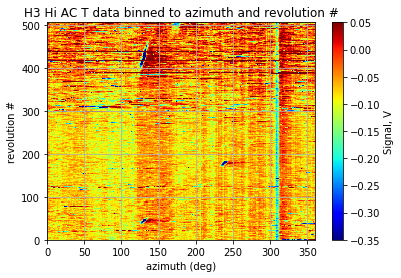

In [56]:
figure()
plotnow_azrevsig(data, az, rt.nametochan(chan), var, minmax = [-0.35,0.05])

[]

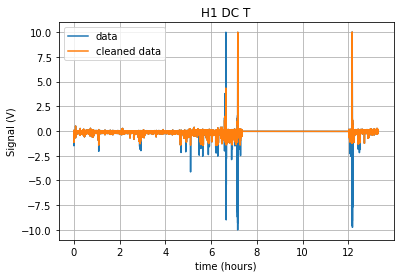

In [57]:
plt.figure()
plt.plot((ut-ut[0])/3600.,data, label='data')
plt.plot((utcleaned-utcleaned[0])/3600.,Tfinal, label='cleaned data')
plt.xlabel('time (hours)')
plt.ylabel('Signal (V)')
plt.title('H1 DC T')
plt.grid()
plt.legend()
plt.plot()

[]

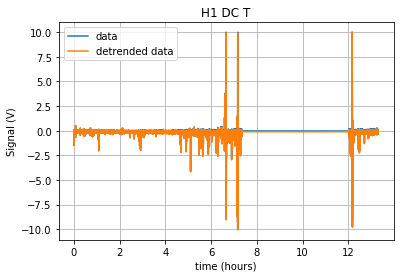

In [58]:
plt.figure()
plt.plot((ut-ut[0])/3600.,data, label='data')
plt.plot((ut-ut[0])/3600.,signal.detrend(data)+data[0], label='detrended data')
plt.xlabel('time (hours)')
plt.ylabel('Signal (V)')
plt.title('H1 DC T')
plt.grid()
plt.legend()
plt.plot()

In [59]:
isort = argsort(azcleaned)
xa = azcleaned[isort]
datas = Tfinal[isort]
ut_sort = utcleaned[isort]

In [60]:
skymean = Tfinal.mean()
print skymean

-0.05641122993097168


In [61]:
offset = stats.binned_statistic(azcleaned, Tfinal, 'mean', bins=360)[0] - skymean
offset_std = stats.binned_statistic(azcleaned, Tfinal, 'std', bins=360)[0]
binned_az = np.arange(0,360)

In [62]:
len(np.linspace(0,359,359))

359

In [64]:
offset_full = np.interp(xa, binned_az, offset)
offset_std_full = np.interp(xa, binned_az, offset_std)

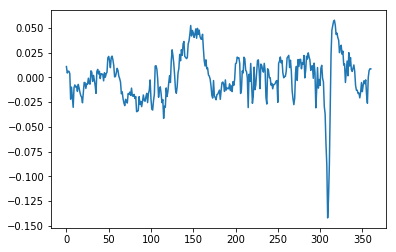

In [65]:
plt.figure()
plt.plot(xa ,offset_full)

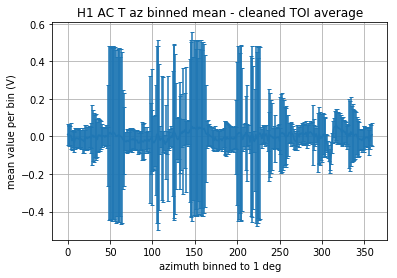

In [66]:
plt.figure()
plt.errorbar(binned_az, offset,yerr=offset_std, fmt='-', capsize=2)
plt.xlabel('azimuth binned to 1 deg')
plt.ylabel('mean value per bin (V)')
plt.title('H1 AC T az binned mean - cleaned TOI average')
plt.grid()

In [67]:
isort2 = argsort(ut_sort)
offset_sort = offset_full[isort2]

In [68]:
data_clean = Tfinal-offset_sort

509


C:\Users\labuser\anaconda3\envs\py27\lib\site-packages\ipykernel_launcher.py:80: RuntimeWarning: Mean of empty slice.


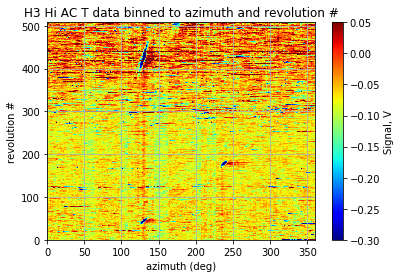

In [69]:
figure()
plotnow_azrevsig(data_clean, azcleaned, rt.nametochan(chan), var, minmax = [-0.3,0.05])

In [70]:
sigc, AZc, REVc = plotnow_azrevsig(data_clean, azcleaned, rt.nametochan(chan), var, minmax = None, return_map=True)
sig, AZ, REV = plotnow_azrevsig(data, az, rt.nametochan(chan), var, minmax = None, return_map=True)

509


C:\Users\labuser\anaconda3\envs\py27\lib\site-packages\ipykernel_launcher.py:80: RuntimeWarning: Mean of empty slice.


508


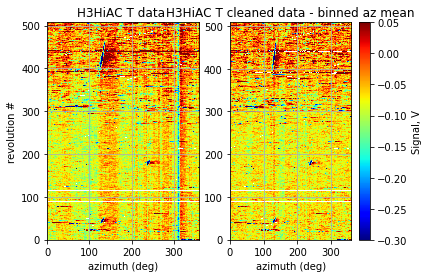

In [71]:
plt.figure()

plt.subplot(1,2,1)
plt.imshow(sig, vmin = -0.3, vmax = 0.05, cmap='jet', origin='lower', aspect='auto')
plt.xlabel('azimuth (deg)')
plt.ylabel('revolution #')
plt.title('%s %s data ' % (chan, var))

#plt.title('demodulated data')
plt.grid()

plt.subplot(1, 2, 2)
im = plt.imshow(sigc, vmin = -0.3, vmax = 0.05, cmap='jet', origin='lower', aspect='auto')
plt.xlabel('azimuth (deg)')
plt.title('%s %s cleaned data - binned az mean' % (chan, var))

plt.grid()
plt.colorbar(label = 'Signal, V')

[]

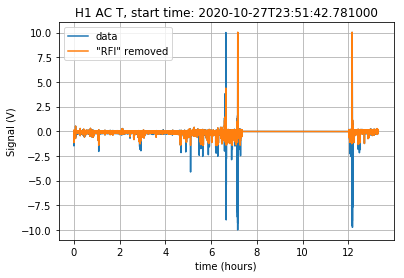

In [72]:
plt.figure()
plt.plot((ut-ut[0])/3600.,data, label='data')
plt.plot((utcleaned-utcleaned[0])/3600.,data_clean, label='"RFI" removed')
plt.xlabel('time (hours)')
plt.ylabel('Signal (V)')
plt.title('H1 AC T, start time: %s' % datetime.datetime.fromtimestamp(ut[0]).isoformat())
plt.grid()
plt.legend()
plt.plot()